This will be the code for the kappa maps and seeing if anything good is derived out of them. First I will jus try to get it pretraining to see if there is any good effect from it.

In [1]:
import numpy as np
import math
import time, os, random
import pickle
from tqdm import tqdm
from functools import partial
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
import wandb

import torch
import torch.nn as nn
import torchvision
#import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torchvision.transforms import ToPILImage,ToTensor, Compose, Normalize,Resize
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

from my_utils.mae_dataloader import  kids450_files_cluster, mae_kids450
from my_utils.mae_collate import mae_collate_fn
from my_utils.mae_base import MaskedAutoencoderViT

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import PatchEmbed, Block
from my_utils.pos_embeds import get_2d_sincos_pos_embed

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available, using CPU.")

GPU is available.


Define the dataloader

In [3]:
file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 128
resolution = 128

train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
valid_data = mae_kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
test_data =  mae_kids450(phase = "test",file_paths = file_paths_test,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 40)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 40)
kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 40)

print(f'Length of test data: {len(train_data)}')
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available, using CPU.")

Length of test data: 456000
GPU is available.


/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [4]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
#get model
def mae_vit_base_patch8(**kwargs):
    model = MaskedAutoencoderViT(
        img_size=128, patch_size=8, in_chans=4, embed_dim=768, depth=12, num_heads=4,
        decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=4,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model
#mae_vit_base_patch16 = mae_vit_base_patch16

In [5]:
#to get test samples
dataiter = iter(kids_train_loader)
#images, labels = next(dataiter)
cifar_im = next(dataiter)[0]
cifar_im.shape

torch.Size([128, 4, 128, 128])

In [2]:
#mae_vit_base_patch16 = mae_vit_base_patch16()
model = mae_vit_base_patch8().to(device)
loss, _, _ = model(cifar_im.to(device), mask_ratio=0.75)
#data atleast is passing trough , that is a start

NameError: name 'mae_vit_base_patch8' is not defined

In [6]:
def main(config):
    setup_seed(config.seed)

    batch_size = config.batch_size
    load_batch_size = min(config.max_device_batch_size, batch_size)

    assert batch_size % load_batch_size == 0
    steps_per_update = batch_size // load_batch_size

    #train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=Compose([ToTensor(),Resize((224, 224)), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    
    
    file_paths_train, file_paths_test = kids450_files_cluster()
    batch_size = 128
    resolution = 128


    
    train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
    #valid_data = mae_kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
    kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 60)
    #kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 60)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = mae_vit_base_patch8().to(device)

    optim = torch.optim.AdamW(model.parameters(), lr=config.base_learning_rate * config.batch_size / 256, betas=(0.9, 0.95), weight_decay=config.weight_decay)
    lr_func = lambda epoch: min((epoch + 1) / (config.warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / config.total_epoch * math.pi) + 1))
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)

    
    wandb.watch(model, log="all", log_freq=100)
    step_count = 0
    optim.zero_grad()
    for e in range(config.total_epoch):
        model.train()
        stime = time.time()
        losses = []
        for img,label in tqdm(iter(kids_train_loader)):
            step_count += 1
            img = img.to(device)# images to gpu
            loss, _, _ = model(img, mask_ratio=config.mask_ratio)
            wandb.log({"epoch": e+1, "loss": loss}, step=step_count)
            loss.backward()
            if step_count % steps_per_update == 0:
                optim.step()
                optim.zero_grad()
            losses.append(loss.item())
        lr_scheduler.step()
        time_taken = (time.time()-stime)/60
        avg_loss = sum(losses) / len(losses)
        #writer.add_scalar('mae_loss', avg_loss, global_step=e)
        print(f'In epoch {e}, average traning loss is {avg_loss}.')
        wandb.log({"Time taken per epoch": time_taken,
           "Training loss per epoch": avg_loss,
           #"Validation loss per epoch": val_per_epoch,
           "Lr per epoch " : optim.param_groups[0]["lr"]})
        train_data.on_epoch_end()   
        ''' save model '''
        torch.save(model.state_dict(),config.model_path)

In [7]:
import gc

# Clear cache
torch.cuda.empty_cache()
# Manual garbage collection

gc.collect()

0

In [10]:
config = {
    "seed" : 42,
    "batch_size" : 1024,#4096,
    "max_device_batch_size" : 256,#512,
    "mask_ratio" : 0.75,
    "base_learning_rate": 1.5e-4,
    "weight_decay" : 0.05,
    "mask_ratio" : 0.75,
    "total_epoch" : 2000,
    "warmup_epoch" : 200,
    "model_path" : "vit_t_mae_kids450_meta.pt",
    }

if __name__ == "__main__":
    wandb.login()
    # tell wandb to get started
    with wandb.init(project="mae_kids450", config=config):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config 
        device = 0  # shorthand for cuda:0
        main(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aaditep (atepper). Use `wandb login --relogin` to force relogin


Traceback (most recent call last):
  File "/scratch/tmp.3879433.atepper/ipykernel_44060/3547218557.py", line 21, in <module>
    main(config)
    ^^^^
NameError: name 'main' is not defined


NameError: name 'main' is not defined

In [5]:
file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 128
resolution = 128

train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
valid_data = mae_kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
test_data =  mae_kids450(phase = "test",file_paths = file_paths_test,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 40)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 40)
kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 40)

print(f'Length of test data: {len(train_data)}')
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available, using CPU.")

Length of test data: 456000
GPU is available.


/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [13]:
#get model
def mae_vit_base_patch8(config):
    """inputs with config file"""
    model = MaskedAutoencoderViT(
        img_size = config["img_size"], patch_size = config["patch_size"], in_chans = config["in_chans"],
        embed_dim = config["embed_dim"], depth = config["depth"], num_heads = config["num_heads"],
        decoder_embed_dim = config["decoder_embed_dim"], decoder_depth = config["decoder_depth"],
        decoder_num_heads = config["decoder_num_heads"], mlp_ratio = config["mlp_ratio"],
        norm_layer = partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

config = {
    "seed" : 42,
    "batch_size" : 1024,#4096,
    "max_device_batch_size" : 512,#512,
    "mask_ratio" : 0.75,
    "base_learning_rate": 1.5e-2,
    "weight_decay" : 0.05,
    "mask_ratio" : 0.75,
    "total_epoch" : 2000,
    "warmup_epoch" : 200,
    "model_path" : "mae_test_32.pt",
    "img_size" : 128,
    "patch_size": 16,
    "in_chans" : 4,
    "embed_dim" : 768,
    "depth" : 8,
    "num_heads" : 4,
    "decoder_embed_dim" : 768,
    "decoder_depth" : 8,
    "decoder_num_heads" : 4,
    "mlp_ratio" : 4,
    }

kwargs = {
    "proj_drop" : 0.2,
    "attn_drop" : 0.2,

}
def patch2img(x,patch_size = 16, image_size = 128):
    patch_size = patch_size
    image_size = image_size
    return Rearrange('b (h w) (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)(x)

def unpatchify( x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    
    p = 16
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 4))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 4, h * p, h * p))
    return imgs

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = mae_vit_base_patch8(config).to(device)
state_dict = torch.load("vit_t_mae_kids450_meta_16pix_test.pt")
model.load_state_dict(state_dict)#.to(device)

file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 16
resolution = 128

valid_data = mae_kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 40)

#train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=Compose([ToTensor(),Resize((224, 224)), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
#trainloader = torch.utils.data.DataLoader(train_dataset, 128, shuffle=False, num_workers=40)

#dataiter = iter(trainloader)
#images, labels = next(dataiter)
#cifar_im = next(dataiter)[0][0].unsqueeze(0)
#cifar_im.shape

{'proj_drop': 0.2, 'attn_drop': 0.2}
not using norm pix loss


/scratch/tmp.3886335.atepper/ipykernel_162560/3602186999.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("vit_t_mae_kids450_meta_16pix_test.pt")


In [8]:
#to get test samples
dataiter = iter(kids_valid_loader )
#images, labels = next(dataiter)
cifar_im = next(dataiter)[0][0].unsqueeze(0)
cifar_im.shape

torch.Size([1, 4, 128, 128])

In [19]:
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
val_img.shape

torch.Size([16, 4, 128, 128])

torch.Size([16, 64, 1024])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])


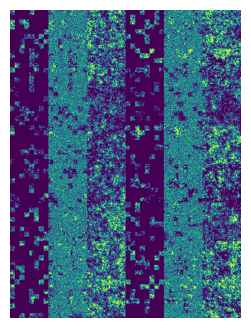

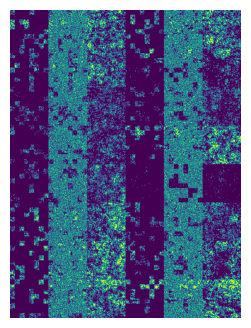

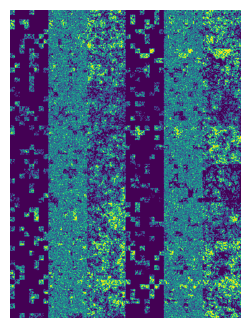

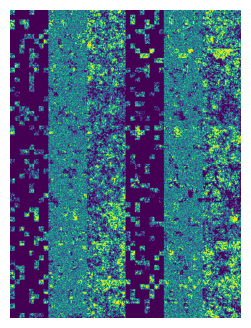

In [9]:
#do one as  per channel, since for the cosmo images I have 4 channel images.
dataiter = iter(kids_valid_loader )
#val_img = torch.stack([train_dataset[i][0] for i in range(16)])
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
loss, predicted_val_img, mask = model(val_img,mask_ratio  =0.75)
print(predicted_val_img.shape)

predicted_val_img = patch2img(predicted_val_img)
print(predicted_val_img.shape)
mask = mask.unsqueeze(-1).expand(-1, -1, 1024) #eshape for patching
mask = patch2img(mask)
print(mask.shape)


channels = 4
for i in range(channels):
    predicted_val_img_1chan = predicted_val_img[:,i,:,:].unsqueeze(1)
    #print(predicted_val_img.shape)
    val_img_1chan = val_img[:,i,:,:].unsqueeze(1)
    mask_1chan = mask[:,i,:,:].unsqueeze(1)

    
    predicted_val_img_1chan = predicted_val_img_1chan * mask_1chan + val_img_1chan * (1 - mask_1chan)
    img = torch.cat([val_img_1chan * (1 - mask_1chan), predicted_val_img_1chan, val_img_1chan], dim=0)
    img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
    #writer.add_image('mae_image', (img + 1) / 2, global_step=e)
    plt.figure(figsize=(4, 4))
    #print(f"plotting image{images.shape}")
    plt.imshow(ToPILImage()(img.cpu()))
    #print(img.shape)
    plt.axis("off")
    #plt.savefig("test_cosmo.png")
    plt.show()

In [14]:
dataiter = iter(kids_valid_loader )
#val_img = torch.stack([train_dataset[i][0] for i in range(16)])
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
loss, predicted_val_img, mask = model(val_img,mask_ratio  =0.5)
predicted_val_img = unpatchify(predicted_val_img)
#predicted_val_img = patch2img(predicted_val_img)
unpatchify
print(predicted_val_img.shape)
mask = mask.unsqueeze(-1).expand(-1, -1, 1024) #eshape for patching
#mask = patch2img(mask)
mask = unpatchify(mask)
print(mask.shape)
#get rid of unpredicted patches and replace with real
predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)

torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])


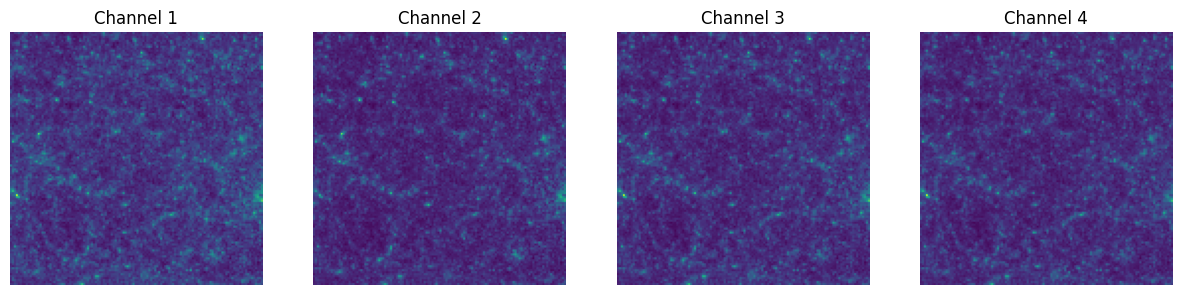

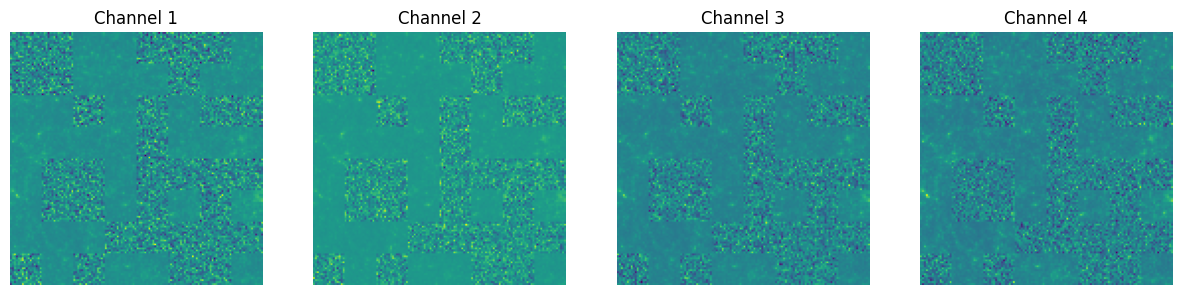

In [15]:
element_from_batch = 1
val_img = val_img[element_from_batch]
pred_img = predicted_val_img[element_from_batch]
#original image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    #print(test_im[i].shape)
    #test_im = (test_im - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)
    axes[i].imshow(val_img[i].cpu().detach(), cmap = "viridis")
    #axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()
#predicted image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    #print(test_im[i].shape)
    #test_im = (test_im - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)
    axes[i].imshow(pred_img[i].cpu().detach(), cmap = "viridis")
    #axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()

Take stats of the data from work cluster

In [15]:
path = "/cluster/work/refregier/atepper/kids_450/full_data/kids450_train_stats.pkl"
import pickle
with open(path, 'rb') as file:
    data = pickle.load(file)

In [16]:
data

{'mean_labels': tensor([0.2665, 0.8426]),
 'label_std_deviation': tensor([0.1080, 0.2284]),
 'mean_pixel_values': tensor([[[[ 1.7944e-13]],
 
          [[-9.2091e-14]],
 
          [[-1.8305e-13]],
 
          [[ 4.7488e-13]]]]),
 'pixel_std_deviation': tensor([[[[0.0079]],
 
          [[0.0065]],
 
          [[0.0093]],
 
          [[0.0116]]]]),
 'Overall_max_values': tensor([[[[1.1729]],
 
          [[1.2491]],
 
          [[1.3330]],
 
          [[1.3701]]]]),
 'Overall_min_values': tensor([[[[-0.0301]],
 
          [[-0.0225]],
 
          [[-0.0325]],
 
          [[-0.0409]]]])}

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr=config.base_learning_rate * config.batch_size / 256, betas=(0.9, 0.95), weight_decay=config.weight_decay)
lr_func = lambda epoch: min((epoch + 1) / (config.warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / config.total_epoch * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)
1.5e-2

In [38]:
lr_func = lambda epoch: min((epoch + 1) / (200 + 1e-8), 0.5 * (math.sin(epoch / 2000 * math.pi) + 1))

In [26]:
lr_func(6)*1.5e-2

0.00052499999997375

In [60]:
lr_values[-3]

7.501876218491077e-05

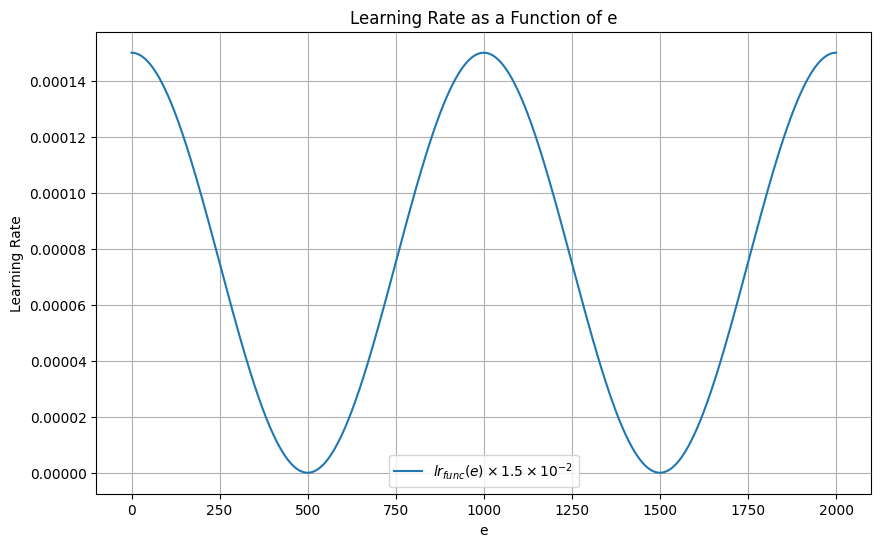

In [84]:
#lr_func = lambda epoch: (-epoch ) / (200 + 1e-8) + 10
lr_func = lambda epoch: 0.005 * (math.cos(epoch / 500* math.pi) +1 )

base_lr = 1.5e-2
e_values = np.linspace(0, 2000, 4000)  # 4000 points for smooth curve
#lr_values = lr_func(e_values) * base_lr
lr_values = np.array([lr_func(e) for e in e_values]) * 1.5e-2

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(e_values, lr_values, label=r'$lr_{func}(e) \times 1.5 \times 10^{-2}$')
plt.xlabel('e')
plt.ylabel('Learning Rate')
plt.title('Learning Rate as a Function of e')
plt.legend()
plt.grid(True)
plt.show()

## Testing here 2 runs:
*One with the 128 pixel images 0.5 mask and .03-1.0 resize ratio

*Another with 0.7 masking to 0.7-1.0 resize 

In [9]:
#The 128 model
def mae_vit_base_patch8(config):
    """inputs with config file"""
    model = MaskedAutoencoderViT(
        img_size = config["img_size"], patch_size = config["patch_size"], in_chans = config["in_chans"],
        embed_dim = config["embed_dim"], depth = config["depth"], num_heads = config["num_heads"],
        decoder_embed_dim = config["decoder_embed_dim"], decoder_depth = config["decoder_depth"],
        decoder_num_heads = config["decoder_num_heads"], mlp_ratio = config["mlp_ratio"],
        norm_layer = partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

config = {
    "seed" : 42,
    "batch_size" : 1024,#4096,
    "max_device_batch_size" : 512,#512,
    "mask_ratio" : 0.5,
    "base_learning_rate": 1.5e-3,
    "weight_decay" : 0.05,
    "mask_ratio" : 0.75,
    "total_epoch" : 2000,
    "warmup_epoch" : 200,
    "model_path" : "mae_test_32.pt",
    "img_size" : 128,
    "patch_size": 16,
    "in_chans" : 4,
    "embed_dim" : 768,
    "depth" : 12,
    "num_heads" : 12,
    "decoder_embed_dim" : 512,
    "decoder_depth" : 8,
    "decoder_num_heads" : 16,
    "mlp_ratio" : 4,
    "save_every" : 5,
    "norm_pix_loss" : False,
    "continue_previous_train" : False,
    "last_epoch" : 315,
    }

kwargs = {
    "proj_drop" : 0.2,
    "attn_drop" : 0.2,

}
def patch2img(x,patch_size = 16, image_size = 128):
    patch_size = patch_size
    image_size = image_size
    return Rearrange('b (h w) (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)(x)

def unpatchify( x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    
    p = 16
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 4))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 4, h * p, h * p))
    return imgs
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
setup_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
main_path = "/cluster/work/refregier/atepper/saved_models_mae/"
run_name = "mae_huge_normed_50_platou"
epoch_nr = 315
load_path = main_path +run_name +"/" +run_name+ "_epoch_"+str(epoch_nr)+".pt"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = mae_vit_base_patch8(config).to(device)
state_dict = torch.load(load_path)
model.load_state_dict(state_dict["model_state_dict"])#.to(device)



file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 6
resolution = 128

valid_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)
train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)

{'proj_drop': 0.2, 'attn_drop': 0.2}
not using norm pix loss


/scratch/tmp.3886335.atepper/ipykernel_271175/77081863.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path)


torch.Size([6, 4, 128, 128])


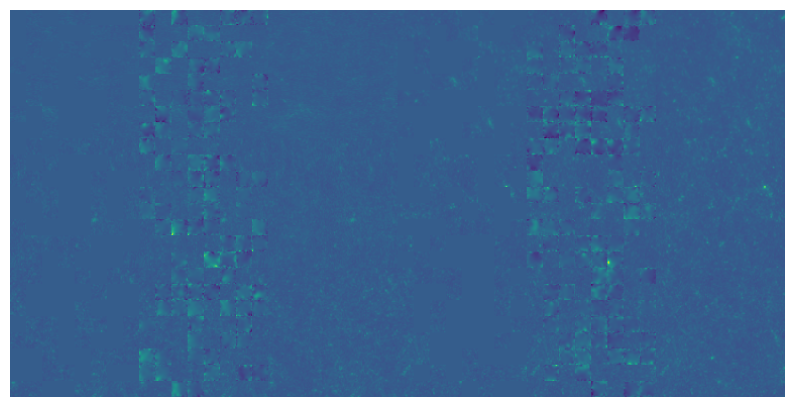

torch.Size([6, 4, 128, 128])


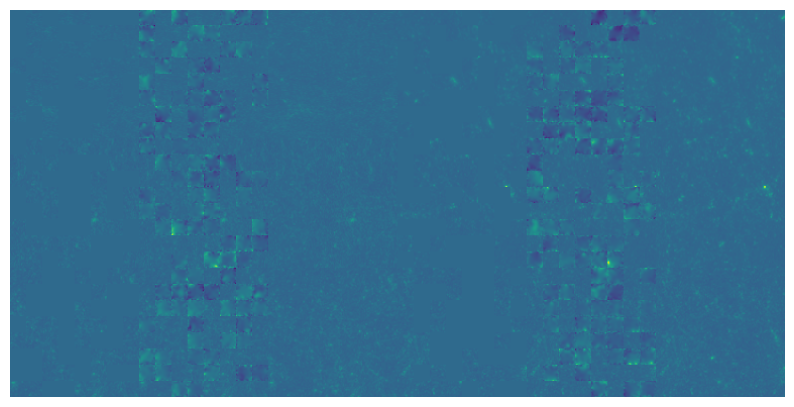

torch.Size([6, 4, 128, 128])


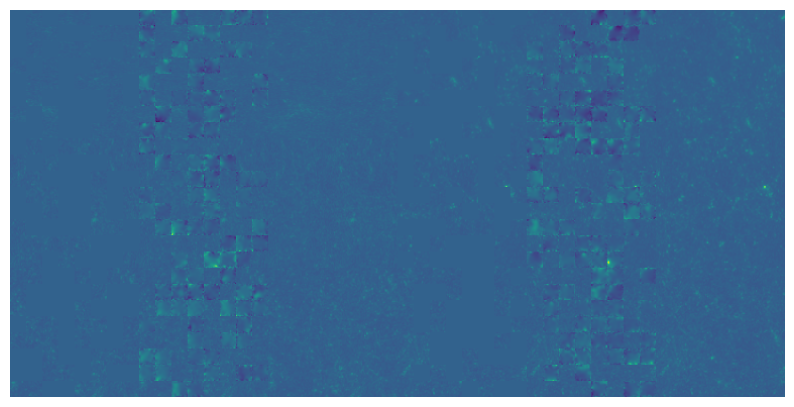

torch.Size([6, 4, 128, 128])


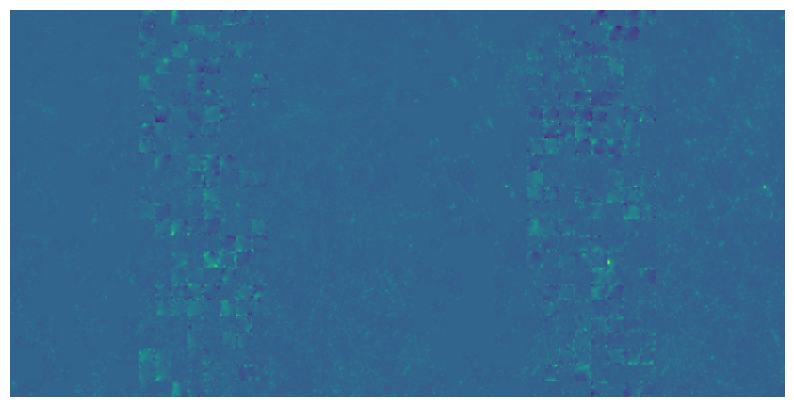

In [11]:
#do one as  per channel, since for the cosmo images I have 4 channel images.
dataiter = iter(kids_train_loader )
#val_img = torch.stack([train_dataset[i][0] for i in range(16)])
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
loss, predicted_val_img, mask = model(val_img,mask_ratio  =0.5)


#predicted_val_img = patch2img(predicted_val_img)
predicted_val_img = unpatchify(predicted_val_img) #fix

mask = mask.unsqueeze(-1).expand(-1, -1, 1024) #eshape for patching
mask = unpatchify(mask) #fix
#mask = patch2img(mask)



channels = 4
for i in range(channels):
    predicted_val_img_1chan = predicted_val_img[:,i,:,:].unsqueeze(1)
    print(predicted_val_img.shape)
    val_img_1chan = val_img[:,i,:,:].unsqueeze(1)
    mask_1chan = mask[:,i,:,:].unsqueeze(1)
    #plt.imshow(ToPILImage()(predicted_val_img_1chan[0][0].cpu()))
    #plt.show()
    #plt.imshow(predicted_val_img_1chan[0][0].detach().cpu())
    #plt.show()
    predicted_val_img_1chan = predicted_val_img_1chan * mask_1chan + val_img_1chan * (1 - mask_1chan)
    img = torch.cat([val_img_1chan * (1 - mask_1chan), predicted_val_img_1chan, val_img_1chan], dim=0)
    img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
   
    plt.figure(figsize=(10, 10))
    plt.imshow(img.squeeze(0).detach().cpu())
    #plt.imshow(ToPILImage()(img.cpu()))
    plt.axis("off")
    #plt.savefig("test_cosmo.pdf")
    plt.show()

torch.Size([6, 4, 128, 128])
torch.Size([6, 4, 128, 128])


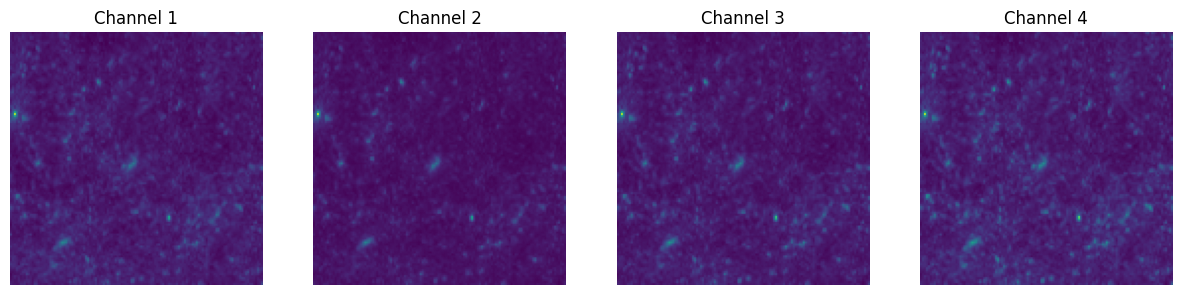

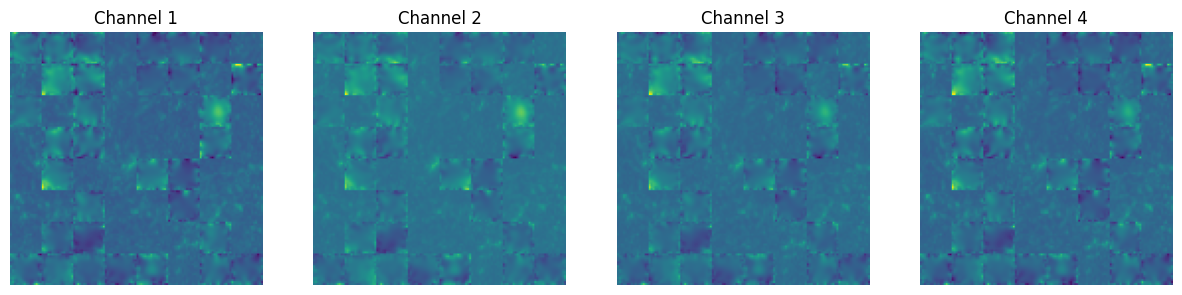

In [13]:
dataiter = iter(kids_train_loader )
#val_img = torch.stack([train_dataset[i][0] for i in range(16)])
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
loss, predicted_val_img, mask = model(val_img,mask_ratio  =0.5)
predicted_val_img = unpatchify(predicted_val_img)                              
#predicted_val_img = patch2img(predicted_val_img)
print(predicted_val_img.shape)
mask = mask.unsqueeze(-1).expand(-1, -1, 1024) #eshape for patching
mask = patch2img(mask)
print(mask.shape)
#get rid of unpredicted patches and replace with real
predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)

element_from_batch = 1
val_img = val_img[element_from_batch]
pred_img = predicted_val_img[element_from_batch]
#original image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    #print(test_im[i].shape)
    #test_im = (test_im - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)
    #axes[i].imshow(val_img[i].cpu().detach(), cmap = "viridis")
    axes[i].imshow(val_img[i].cpu().detach(), cmap = "viridis")
    #axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()
#predicted image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    #print(test_im[i].shape)
    #test_im = (test_im - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)
    #axes[i].imshow(pred_img[i].cpu().detach(), cmap = "viridis")
    axes[i].imshow(pred_img[i].cpu().detach(), cmap = "viridis")
    #axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()

In [53]:
def patchify(imgs):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    c = imgs.shape[1]
    p = 16
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], c, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * c))
    return x
def patch2img(x,patch_size = 16, image_size = 32):
    patch_size = patch_size
    image_size = image_size
    return Rearrange('b (h w) (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)(x)


def unpatchify( x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    
    p = 16
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

In [4]:
#THe 224 model

def mae_vit_base_patch8(config):
    """inputs with config file"""
    model = MaskedAutoencoderViT(
        img_size = config["img_size"], patch_size = config["patch_size"], in_chans = config["in_chans"],
        embed_dim = config["embed_dim"], depth = config["depth"], num_heads = config["num_heads"],
        decoder_embed_dim = config["decoder_embed_dim"], decoder_depth = config["decoder_depth"],
        decoder_num_heads = config["decoder_num_heads"], mlp_ratio = config["mlp_ratio"],
        norm_layer = partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


config = {
    "seed" : 62,
    "batch_size" : 1024,#4096,
    "max_device_batch_size" : 128,#512,
    "mask_ratio" : 0.7,
    "base_learning_rate": 1e-4,
    "weight_decay" : 0.01,#0.05
    "total_epoch" : 500,
    "warmup_epoch" : 10,
    "run_name" : "mae_base_224_normed_sml_lr_drop",
    "img_size" : 224,
    "patch_size": 16,
    "in_chans" : 4,
    "embed_dim" : 768,
    "depth" : 12,
    "num_heads" : 12,
    "decoder_embed_dim" : 512,
    "decoder_depth" : 8,
    "decoder_num_heads" : 16,
    "mlp_ratio" : 4.,
    "save_every" : 5,
    "norm_pix_loss" : False,
    "continue_previous_train" : False,
    "last_epoch" : 0,
    }

kwargs = {
    "proj_drop" : 0.2,
    "attn_drop" : 0.2,

}
def unpatchify( x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    
    p = 16
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 4))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 4, h * p, h * p))
    return imgs
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
setup_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
main_path = "/cluster/work/refregier/atepper/saved_models_mae/"
run_name = "mae_base_224_normed_sml_lr_drop"
epoch_nr = 40
load_path = main_path +run_name +"/" +run_name+ "_epoch_"+str(epoch_nr)+".pt"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = mae_vit_base_patch8(config).to(device)
state_dict = torch.load(load_path)
model.load_state_dict(state_dict["model_state_dict"])#.to(device)



file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 6
resolution = 224

valid_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)
train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)

{'proj_drop': 0.2, 'attn_drop': 0.2}
not using norm pix loss


/scratch/tmp.3886335.atepper/ipykernel_271175/3282706466.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path)
/cluster/home/atepper/thesis_

torch.Size([6, 4, 224, 224])


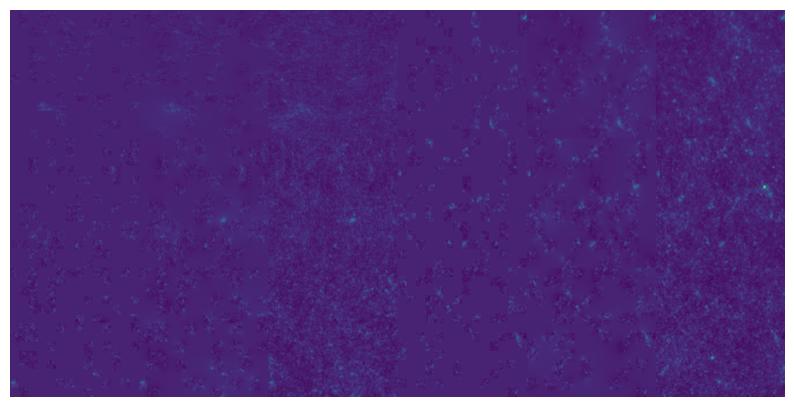

torch.Size([6, 4, 224, 224])


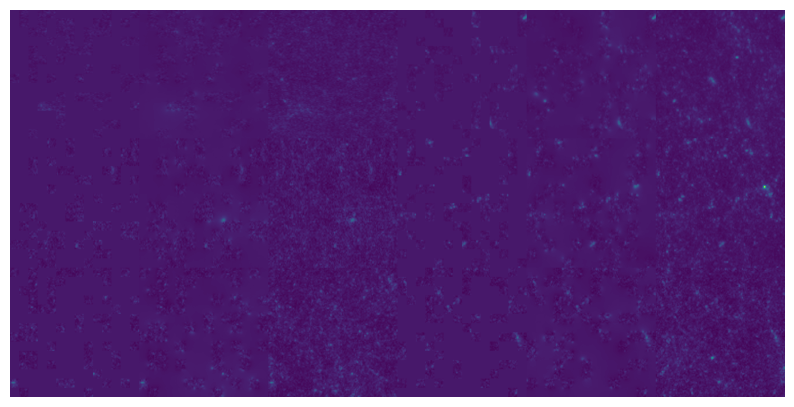

torch.Size([6, 4, 224, 224])


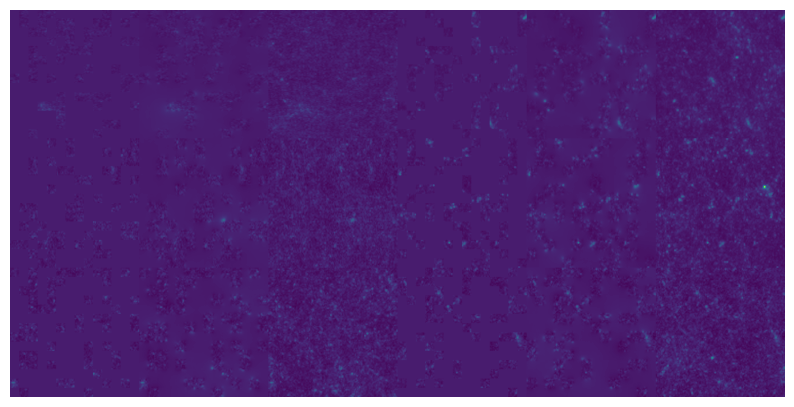

torch.Size([6, 4, 224, 224])


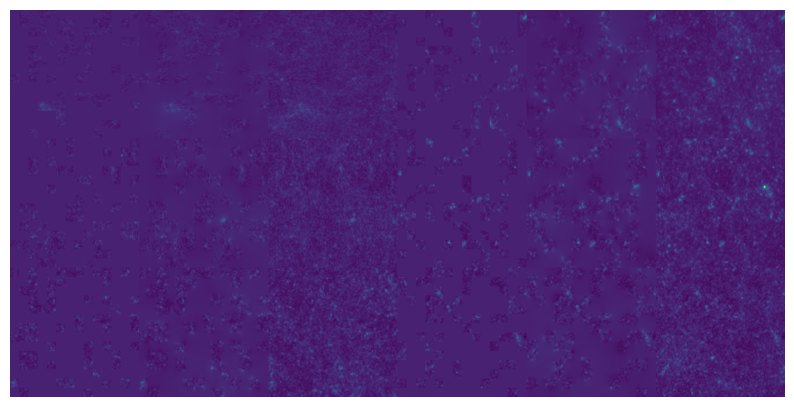

In [6]:
#do one as  per channel, since for the cosmo images I have 4 channel images.
dataiter = iter(kids_train_loader )
#val_img = torch.stack([train_dataset[i][0] for i in range(16)])
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
loss, predicted_val_img, mask = model(val_img,mask_ratio  =0.7)


#predicted_val_img = patch2img(predicted_val_img)
predicted_val_img = unpatchify(predicted_val_img) #fix

mask = mask.unsqueeze(-1).expand(-1, -1, 1024) #eshape for patching
mask = unpatchify(mask) #fix
#mask = patch2img(mask)



channels = 4
for i in range(channels):
    predicted_val_img_1chan = predicted_val_img[:,i,:,:].unsqueeze(1)
    print(predicted_val_img.shape)
    val_img_1chan = val_img[:,i,:,:].unsqueeze(1)
    mask_1chan = mask[:,i,:,:].unsqueeze(1)
    #plt.imshow(ToPILImage()(predicted_val_img_1chan[0][0].cpu()))
    #plt.show()
    #plt.imshow(predicted_val_img_1chan[0][0].detach().cpu())
    #plt.show()
    predicted_val_img_1chan = predicted_val_img_1chan * mask_1chan + val_img_1chan * (1 - mask_1chan)
    img = torch.cat([val_img_1chan * (1 - mask_1chan), predicted_val_img_1chan, val_img_1chan], dim=0)
    img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
   
    plt.figure(figsize=(10, 10))
    plt.imshow(img.squeeze(0).detach().cpu())
    #plt.imshow(ToPILImage()(img.cpu()))
    plt.axis("off")
    #plt.savefig("test_cosmo.pdf")
    plt.show()

torch.Size([6, 4, 224, 224])
torch.Size([6, 4, 224, 224])


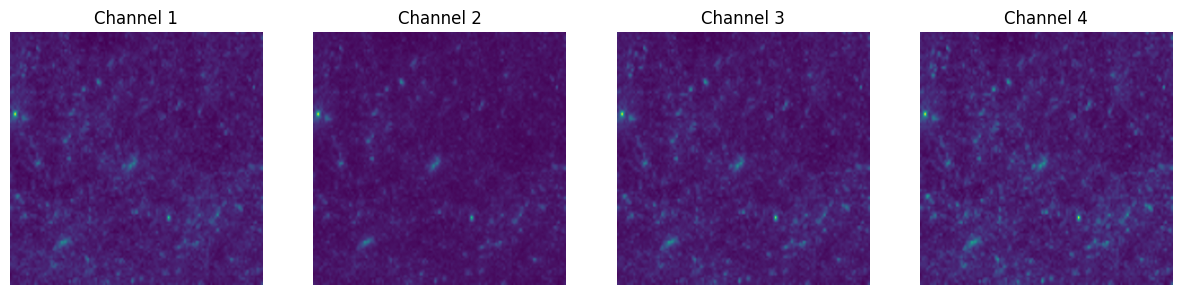

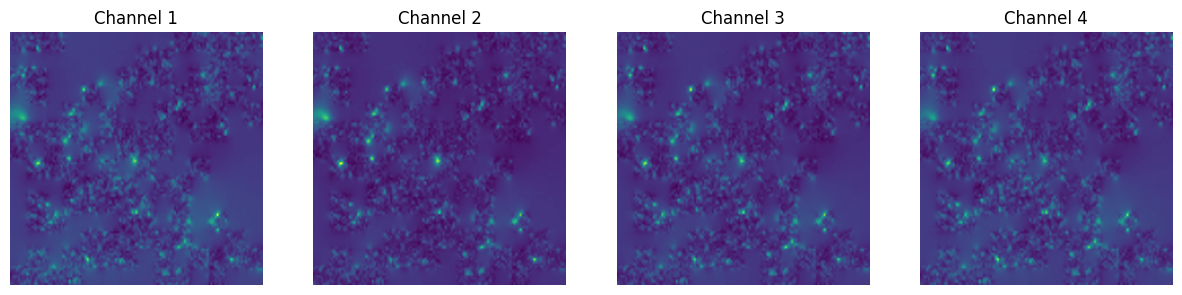

In [8]:
dataiter = iter(kids_train_loader )
#val_img = torch.stack([train_dataset[i][0] for i in range(16)])
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
loss, predicted_val_img, mask = model(val_img,mask_ratio  =0.5)
predicted_val_img = unpatchify(predicted_val_img)                              
#predicted_val_img = patch2img(predicted_val_img)
print(predicted_val_img.shape)
mask = mask.unsqueeze(-1).expand(-1, -1, 1024) #eshape for patching
mask = unpatchify(mask)
print(mask.shape)
#get rid of unpredicted patches and replace with real
predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)

element_from_batch = 1
val_img = val_img[element_from_batch]
pred_img = predicted_val_img[element_from_batch]
#original image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    #print(test_im[i].shape)
    #test_im = (test_im - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)
    #axes[i].imshow(val_img[i].cpu().detach(), cmap = "viridis")
    axes[i].imshow(val_img[i].cpu().detach(), cmap = "viridis")
    #axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()
#predicted image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    #print(test_im[i].shape)
    #test_im = (test_im - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)
    #axes[i].imshow(pred_img[i].cpu().detach(), cmap = "viridis")
    axes[i].imshow(pred_img[i].cpu().detach(), cmap = "viridis")
    #axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()

In [5]:
def mae_vit_base_patch8(config):
    """inputs with config file"""
    model = MaskedAutoencoderViT(
        img_size = config["img_size"], patch_size = config["patch_size"], in_chans = config["in_chans"],
        embed_dim = config["embed_dim"], depth = config["depth"], num_heads = config["num_heads"],
        decoder_embed_dim = config["decoder_embed_dim"], decoder_depth = config["decoder_depth"],
        decoder_num_heads = config["decoder_num_heads"], mlp_ratio = config["mlp_ratio"],
        norm_layer = partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


config = {
    "seed" : 62,
    "batch_size" : 1024,#4096,
    "max_device_batch_size" : 512,#512,
    "mask_ratio" : 0.7,
    "base_learning_rate": 1e-4,
    "weight_decay" : 0.01,#0.05
    "total_epoch" : 500,
    "warmup_epoch" : 10,
    "run_name" : "mae_base_128_not_normed",
    "img_size" : 128,
    "patch_size": 16,
    "in_chans" : 4,
    "embed_dim" : 768,
    "depth" : 12,
    "num_heads" : 12,
    "decoder_embed_dim" : 512,
    "decoder_depth" : 8,
    "decoder_num_heads" : 16,
    "mlp_ratio" : 4.,
    "save_every" : 5,
    "norm_pix_loss" : False,
    "continue_previous_train" : False,
    "last_epoch" : 0,
}
kwargs = {
    "proj_drop" : 0.2,
    "attn_drop" : 0.2,

}
def unpatchify( x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    
    p = 16
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 4))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 4, h * p, h * p))
    return imgs
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [17]:
setup_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
main_path = "/cluster/work/refregier/atepper/saved_models_mae/"
run_name = "mae_base_128_not_normed"
epoch_nr = 110
load_path = main_path +run_name +"/" +run_name+ "_epoch_"+str(epoch_nr)+".pt"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = mae_vit_base_patch8(config).to(device)
state_dict = torch.load(load_path)
model.load_state_dict(state_dict["model_state_dict"])#.to(device)



file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 6
resolution = 128

valid_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)
train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 19)

{'proj_drop': 0.2, 'attn_drop': 0.2}
not using norm pix loss


/scratch/tmp.3950276.atepper/ipykernel_22856/2234277631.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path)


torch.Size([6, 4, 128, 128])


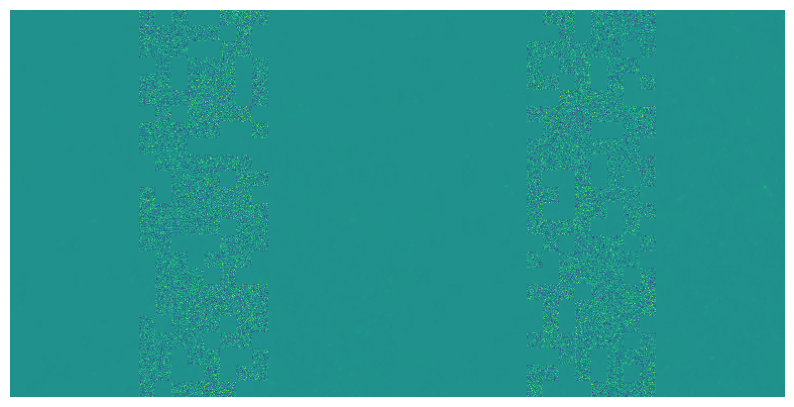

torch.Size([6, 4, 128, 128])


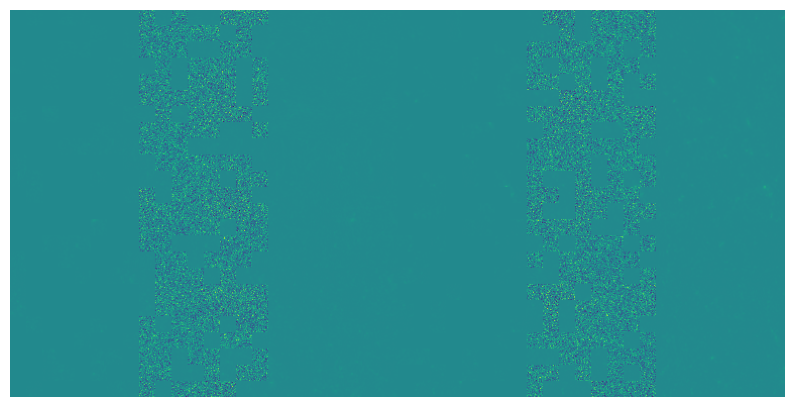

torch.Size([6, 4, 128, 128])


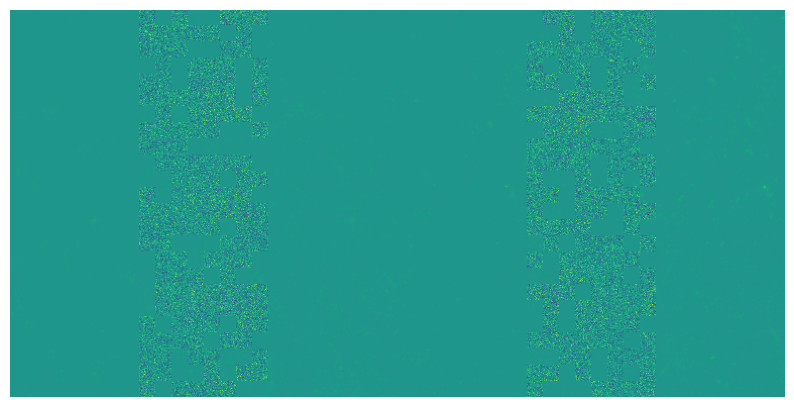

torch.Size([6, 4, 128, 128])


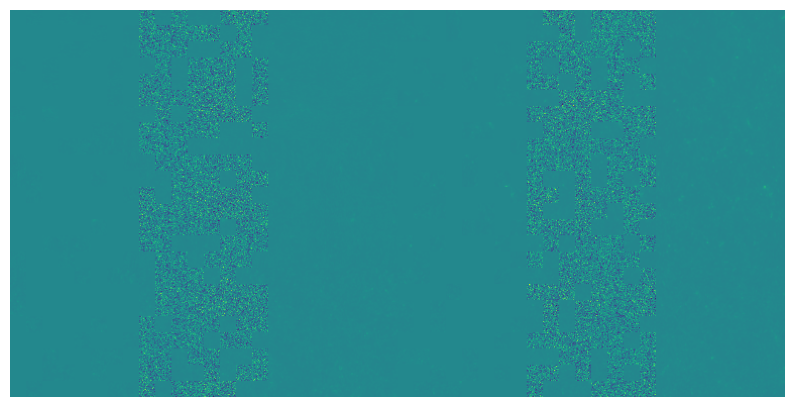

In [18]:
#do one as  per channel, since for the cosmo images I have 4 channel images.
dataiter = iter(kids_train_loader )
#val_img = torch.stack([train_dataset[i][0] for i in range(16)])
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
loss, predicted_val_img, mask = model(val_img,mask_ratio  =0.7)


#predicted_val_img = patch2img(predicted_val_img)
predicted_val_img = unpatchify(predicted_val_img) #fix

mask = mask.unsqueeze(-1).expand(-1, -1, 1024) #eshape for patching
mask = unpatchify(mask) #fix
#mask = patch2img(mask)



channels = 4
for i in range(channels):
    predicted_val_img_1chan = predicted_val_img[:,i,:,:].unsqueeze(1)
    print(predicted_val_img.shape)
    val_img_1chan = val_img[:,i,:,:].unsqueeze(1)
    mask_1chan = mask[:,i,:,:].unsqueeze(1)
    #plt.imshow(ToPILImage()(predicted_val_img_1chan[0][0].cpu()))
    #plt.show()
    #plt.imshow(predicted_val_img_1chan[0][0].detach().cpu())
    #plt.show()
    predicted_val_img_1chan = predicted_val_img_1chan * mask_1chan + val_img_1chan * (1 - mask_1chan)
    img = torch.cat([val_img_1chan * (1 - mask_1chan), predicted_val_img_1chan, val_img_1chan], dim=0)
    img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
   
    plt.figure(figsize=(10, 10))
    plt.imshow(img.squeeze(0).detach().cpu())
    #plt.imshow(ToPILImage()(img.cpu()))
    plt.axis("off")
    #plt.savefig("test_cosmo.pdf")
    plt.show()

torch.Size([6, 4, 128, 128])
torch.Size([6, 4, 128, 128])


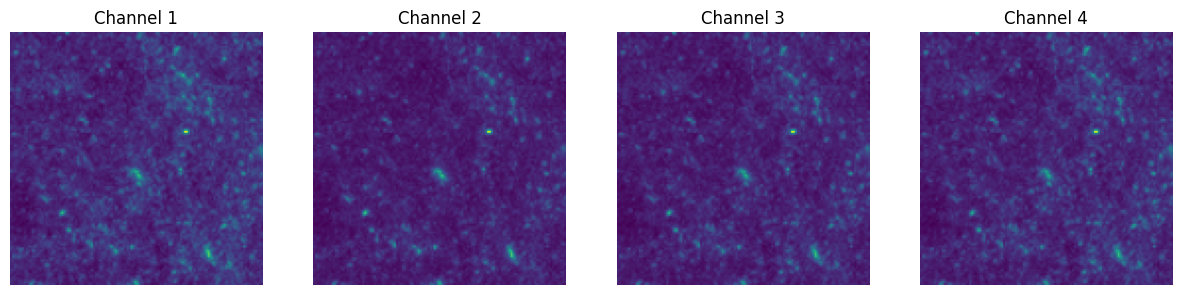

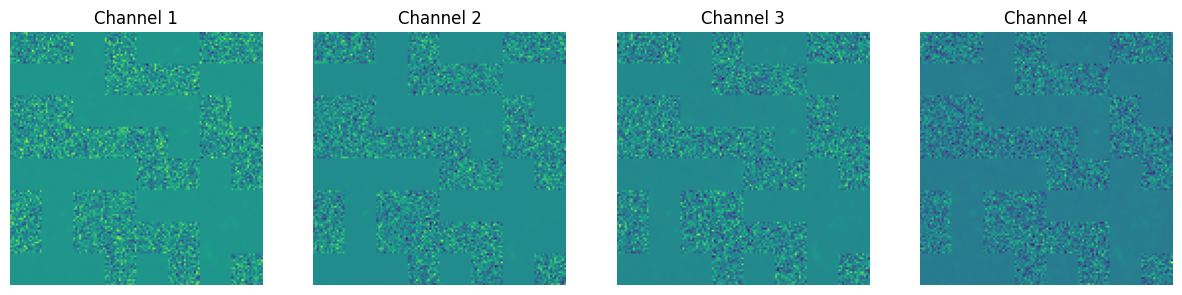

In [19]:
dataiter = iter(kids_train_loader )
#val_img = torch.stack([train_dataset[i][0] for i in range(16)])
val_img =  next(dataiter)[0]
val_img = val_img.to(device)
loss, predicted_val_img, mask = model(val_img,mask_ratio  =0.5)
predicted_val_img = unpatchify(predicted_val_img)                              
#predicted_val_img = patch2img(predicted_val_img)
print(predicted_val_img.shape)
mask = mask.unsqueeze(-1).expand(-1, -1, 1024) #eshape for patching
mask = unpatchify(mask)
print(mask.shape)
#get rid of unpredicted patches and replace with real
predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)

element_from_batch = 1
val_img = val_img[element_from_batch]
pred_img = predicted_val_img[element_from_batch]
#original image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    #print(test_im[i].shape)
    #test_im = (test_im - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)
    #axes[i].imshow(val_img[i].cpu().detach(), cmap = "viridis")
    axes[i].imshow(val_img[i].cpu().detach(), cmap = "viridis")
    #axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()
#predicted image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    #print(test_im[i].shape)
    #test_im = (test_im - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)
    #axes[i].imshow(pred_img[i].cpu().detach(), cmap = "viridis")
    axes[i].imshow(pred_img[i].cpu().detach(), cmap = "viridis")
    #axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()

In [10]:
def random_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))
    
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
    
    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)
    return x_masked, mask, ids_restore